In [119]:
# imports

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

from report_writer import ReportWriter
from utils import ProjectFolders

In [120]:
from sklearn.model_selection import train_test_split

df_final = pd.read_csv(ProjectFolders.FINAL_DATASET_FILE)

DECILE_LABEL = 'decile_score'
TWO_YEAR_REC_LABEL = 'two_year_recid'

y = df_final[DECILE_LABEL].values / 10
y_two_year_recid = df_final[TWO_YEAR_REC_LABEL].values
X = df_final.drop(columns=[DECILE_LABEL]).values

# Train-test split
X_train, X_val, y_train, y_val, y_two_year_recid_train, y_two_year_recid_val_tensor = train_test_split(X, y, y_two_year_recid, test_size=0.2, random_state=42)

# Convert to PyTorch tensors so we can train
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


7489
Epoch [1/5000], Training loss: 0.6585 Validation Loss: 0.6052901744842529
Epoch [2/5000], Training loss: 0.5811 Validation Loss: 0.5405116677284241
Epoch [3/5000], Training loss: 0.5181 Validation Loss: 0.4851103723049164
Epoch [4/5000], Training loss: 0.4646 Validation Loss: 0.43834179639816284
Epoch [5/5000], Training loss: 0.4195 Validation Loss: 0.3986783027648926
Epoch [6/5000], Training loss: 0.3815 Validation Loss: 0.3648293912410736
Epoch [7/5000], Training loss: 0.3493 Validation Loss: 0.3356209695339203
Epoch [8/5000], Training loss: 0.3212 Validation Loss: 0.31011882424354553
Epoch [9/5000], Training loss: 0.2964 Validation Loss: 0.287555456161499
Epoch [10/5000], Training loss: 0.2744 Validation Loss: 0.267567902803421
Epoch [11/5000], Training loss: 0.2549 Validation Loss: 0.24979576468467712
Epoch [12/5000], Training loss: 0.2375 Validation Loss: 0.23386512696743011
Epoch [13/5000], Training loss: 0.2219 Validation Loss: 0.21960985660552979
Epoch [14/5000], Training 

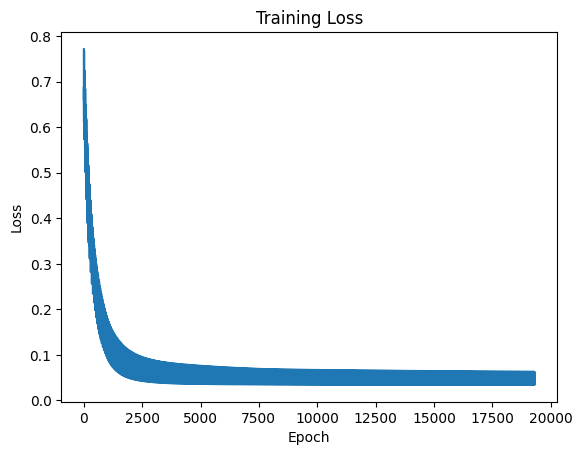

Text(0.5, 1.0, 'Validation Loss')

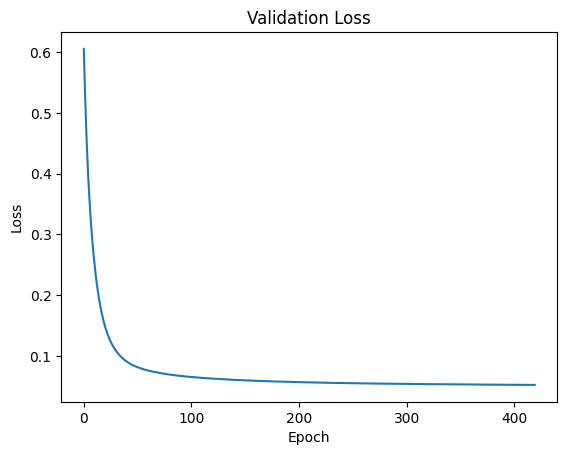

In [121]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Define the model       
layers = [
    nn.Linear(13, 64), nn.BatchNorm1d(64), nn.ReLU(),
    nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
    nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
    nn.Linear(32, 1),
]

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


EPOCHS = 5000
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
EARLY_STOPPING_THRESHOLD = 1e-5

training_samples = X_train_tensor.size(0)
batches_per_epoch = training_samples / BATCH_SIZE

training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    training_loss = 0.0
    correct = 0
    total = 0

    for i in range(0, training_samples, BATCH_SIZE):
        # Mini-batch preparation
        X_batch = X_train_tensor[i:i+BATCH_SIZE]
        y_batch = y_train_tensor[i:i+BATCH_SIZE]

        # Forward pass
        x = X_batch
        for layer in layers:
            x = layer(x)
        
        # Loss calculation
        loss = F.mse_loss(x.squeeze(), y_batch)
        
        # Clear gradients (ensure no accumulation of gradients)
        for p in parameters:
            if p.grad is not None:
                p.grad.zero_()

        # Backward pass
        loss.backward()
        for p in parameters:
            p.data -= LEARNING_RATE * p.grad

        # Track epoch loss
        training_loss += loss.item()
        training_losses.append(loss.item())     
    
    # # Validation loss
    with torch.no_grad():
        # Validation loss
        x = X_val_tensor
        for layer in layers:
            x = layer(x)
        val_loss = F.mse_loss(x.squeeze(), y_val_tensor)
        validation_losses.append(val_loss.item())
    
    # Early stopping
    if epoch > 5 and  abs(validation_losses[-1] - validation_losses[-2]) < EARLY_STOPPING_THRESHOLD:
        print(validation_losses[-1] - validation_losses[-2])
        print(f"Early stopping at epoch {epoch+1}, {validation_losses[-1]}, {validation_losses[-2]}")
        break
    
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Training loss: {training_loss/batches_per_epoch:.4f}", f"Validation Loss: {val_loss}")

plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')



In [122]:
import numpy as np

# Perform predictions on the validation dataset

with torch.no_grad():
    x = X_val_tensor
    for layer in layers:
        x = layer(x)

predictions = x.squeeze()


print(pd.DataFrame(predictions).describe())


print(predictions[0:10])
print(y_val_tensor[0:10])

# print(pd.DataFrame(predictions).describe())   
# print(pd.DataFrame(y_val_tensor).describe())

print(sum(predictions > 0.5))
print(sum(y_val_tensor > 0.5))




                 0
count  1443.000000
mean      0.442938
std       0.200291
min       0.051784
25%       0.285229
50%       0.412162
75%       0.574884
max       1.061122
tensor([0.1746, 0.3547, 0.5811, 0.6871, 0.0897, 0.8482, 0.2398, 0.2475, 0.1673,
        0.2398])
tensor([0.1000, 0.3000, 0.4000, 1.0000, 0.1000, 1.0000, 0.5000, 0.1000, 0.2000,
        0.2000])
tensor(565)
tensor(524)


In [141]:

PROB_RECID_THRESHOLD = 0.5


def categorize_score(score):
    if score <= PROB_RECID_THRESHOLD:
        return 0
    else:
        return 1

# Add the predictions to the dataframe by mapping the categorize_score function to the predictions
# prediction values will be low, medium, or high
prob_recid_tensor = pd.Categorical(
    pd.Series(predictions).map(categorize_score),
)

print(torch.Tensor( predictions[0:10]))
preb_recid_tensor = torch.Tensor(prob_recid_tensor)
y_two_year_recid_tensor = torch.Tensor( y_two_year_recid_val_tensor)




# Initialize counters
counts = {
    "prob_recid": [0, 0, 1, 1],
    "y_two_year_recid_val": [0, 1, 0, 1],
    "count": [0, 0, 0, 0]
}

# Count occurrences
for p, y in zip(preb_recid_tensor, y_two_year_recid_tensor):
    if p == 0 and y == 0:
        counts["count"][0] += 1
    elif p == 0 and y == 1:
        counts["count"][1] += 1
    elif p == 1 and y == 0:
        counts["count"][2] += 1
    elif p == 1 and y == 1:
        counts["count"][3] += 1

# Create DataFrame
df_counts = pd.DataFrame(counts)

# Print DataFrame
print(df_counts)


tensor([0.1746, 0.3547, 0.5811, 0.6871, 0.0897, 0.8482, 0.2398, 0.2475, 0.1673,
        0.2398])
   prob_recid  y_two_year_recid_val  count
0           0                     0    662
1           0                     1    216
2           1                     0    161
3           1                     1    404


In [156]:
import numpy as np
import pandas as pd


print(torch.sum((preb_recid_tensor == 1.0) & (y_two_year_recid_tensor == 1.0)))


# Confusion Matrix Calculation
TP = torch.sum((preb_recid_tensor == 1) & (y_two_year_recid_tensor == 1))  # True Positives
TN = torch.sum((preb_recid_tensor == 0) & (y_two_year_recid_tensor == 0))  # True Negatives
FP = torch.sum((preb_recid_tensor == 1) & (y_two_year_recid_tensor == 0))  # False Positives
FN = torch.sum((preb_recid_tensor == 0) & (y_two_year_recid_tensor == 1))  # False Negatives

# Create Confusion Matrix
confusion_matrix = pd.DataFrame(
    [[TP, FN], [FP, TN]],
    columns=["Actual Positive", "Actual Negative"],
    index=["Predicted Positive", "Predicted Negative"]
)

# Calculate Metrics
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall or True Positive Rate
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate
accuracy = (TP + TN) / (TP + TN + FP + FN)  # Overall accuracy
precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Precision or Positive Predictive Value

# Create Metrics DataFrame
metrics = pd.DataFrame({
    "Metric": ["Sensitivity (Recall)", "Specificity", "Accuracy", "Precision"],
    "Value": [sensitivity, specificity, accuracy, precision]
})

print(metrics)

# # Display Results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Confusion Matrix", dataframe=confusion_matrix)
# tools.display_dataframe_to_user(name="Metrics", dataframe=metrics)


tensor(404)
                 Metric           Value
0  Sensitivity (Recall)  tensor(0.6516)
1           Specificity  tensor(0.8044)
2              Accuracy  tensor(0.7387)
3             Precision  tensor(0.7150)
